In [258]:
import pickle
import pandas as pd
import numpy as np
data_test = pd.read_pickle('results/test_set_results_physchem_split_full_range.pkl')
reals_list = data_test['reals_list']
preds_list = data_test['predictions_test']
print(len(reals_list),len(preds_list))

from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import kendalltau, pearsonr, spearmanr

def model_90_ci(pred, truth, method, method_name="", alpha=0.95):
    stats_per_range = {}
    
    for pred_sample, truth_sample in zip(pred, truth):
        pred_sample = np.array(pred_sample)
        truth_sample = np.array(truth_sample)
        for range_start in range(-12, 10, 1):  # Iterate over dynamic ranges of truth
            mask = (truth_sample >= range_start) & (truth_sample < range_start + 3)
            if np.sum(mask) > 5:  # Ensure there are enough data points in the range
                if range_start not in stats_per_range:
                    stats_per_range[range_start] = []
                stats_per_range[range_start].append(method(pred_sample[mask], truth_sample[mask]))

    ci_results = {}
    
    for range_start, stats in stats_per_range.items():
        p_lower = ((1.0 - alpha) / 2.0) * 100
        p_upper = (alpha + ((1.0 - alpha) / 2.0)) * 100
        lower = np.percentile(stats, p_lower)
        upper = np.percentile(stats, p_upper)
        median = np.median(stats)
        
        ci_results[range_start] = {
            'lower': lower,
            'upper': upper,
            'median': median,
            'all_values': stats  # Store all values
        }
    
    return ci_results

model_results = {
    'Source': [], 'Model': [], 'Range': [], 'Metric': [],
    'Lower': [], 'Upper': [], 'Median': [], 'All_Values': []
}
model_descriptor_combinations = preds_list.keys()
def get_kendall_tau(y_true, y_pred):
    return kendalltau(y_true, y_pred).correlation

def get_pearson_r(y_true, y_pred):
    return pearsonr(y_true, y_pred)[0]

def get_spearman_rho(y_true, y_pred):
    return spearmanr(y_true, y_pred).correlation

def get_fraction_withing_1_log(y_true, y_pred):
    return np.mean(np.abs(np.array(y_true) - np.array(y_pred)) < 1)

descriptors = ['RDKit_PhysChem']
models = ['MLP','RIDGE']
for descriptor in descriptors:
    for model_name in models:
        for method in [r2_score, root_mean_squared_error, mean_absolute_error, get_fraction_withing_1_log, get_kendall_tau, get_pearson_r, get_spearman_rho]:
            range_metrics = model_90_ci(preds_list[descriptor][model_name], reals_list, method)
            for range_start, stats in range_metrics.items():
                model_results['Source'].append('Model')
                model_results['Model'].append(model_name)
                model_results['Range'].append(f"{range_start} to {range_start + 3}")          
                model_results['Metric'].append(method.__name__)
                model_results['Lower'].append(stats['lower'])
                model_results['Upper'].append(stats['upper'])           
                model_results['Median'].append(stats['median'])
                model_results['All_Values'].append(stats['all_values'])  # Add all values

10 1


In [259]:
model_results_df = pd.DataFrame(model_results)
model_results_df

,Source,Model,Range,Metric,Lower,Upper,Median,All_Values
0,Model,MLP,-10 to -7,r2_score,-1.725746,0.078681,-0.728058,"[-1.7924506290556725, 0.001759856970752538, -0..."
1,Model,MLP,-9 to -6,r2_score,-0.424385,0.356422,0.174565,"[-0.2723263446595996, 0.30336271034730666, 0.1..."
2,Model,MLP,-8 to -5,r2_score,-0.485235,0.315284,0.187402,"[0.2031260670434366, 0.10041598363425364, -0.4..."
3,Model,MLP,-7 to -4,r2_score,-0.026544,0.352187,0.118562,"[0.17582057238141502, -0.04430450005797981, 0...."
4,Model,MLP,-6 to -3,r2_score,0.004815,0.382186,0.325336,"[0.3429288582122837, -0.004521768873965826, 0...."
...,...,...,...,...,...,...,...,...
247,Model,RIDGE,3 to 6,get_spearman_rho,0.744731,0.854360,0.822342,"[0.8323351133391345, 0.8484039924028882, 0.794..."
248,Model,RIDGE,4 to 7,get_spearman_rho,0.408773,0.786144,0.713370,"[0.6456964088543035, 0.6403408323241407, 0.700..."
249,Model,RIDGE,5 to 8,get_spearman_rho,0.298894,0.851226,0.555553,"[0.4590626764539809, 0.5278195488721804, 0.279..."
250,Model,RIDGE,-12 to -9,get_spearman_rho,-0.248571,0.077143,-0.085714,"[0.08571428571428573, -0.2571428571428572]"


In [260]:

# Calculate metrics for experimental comparisons
bootstrap_results = {
    'Source': [], 'Model': [], 'Range': [], 'Metric': [],
    'Lower': [], 'Upper': [], 'Median': [], 'All_Values': []
}
df_vps = pd.read_csv('/localhome/cschiebroek/MDFP_VP/mdfptools/carl/group_talk_19_09_2024/vapor_pressures_naef_opera_duplicates.csv')
for i in range(-12, 10, 1):
    df_tmp = df_vps[(df_vps['VP OPERA'] >= i) & (df_vps['VP OPERA'] < i + 3)]
    if len(df_tmp) > 5:
        for method, method_name in [(get_kendall_tau, 'Kendall Tau'), (get_pearson_r, 'Pearson r'), (get_spearman_rho, 'Spearman rho'), 
                                    (r2_score, 'R2'), (root_mean_squared_error, 'RMSE'), (mean_absolute_error, 'MAE'), 
                                    (get_fraction_withing_1_log, 'Fraction within 1 log')]:
            lower, upper, median, all_values = bootstrap_error_estimate(df_tmp['VP Naef&Acree'].values, df_tmp['VP OPERA'].values, method)
            bootstrap_results['Source'].append('Experimental')
            bootstrap_results['Model'].append('Experimental Agreement')
            bootstrap_results['Range'].append(f"{i} to {i + 3}")
            bootstrap_results['Metric'].append(method_name)
            bootstrap_results['Lower'].append(lower)
            bootstrap_results['Upper'].append(upper)
            bootstrap_results['Median'].append(median)
            bootstrap_results['All_Values'].append(all_values)  # Add all values

# Convert to DataFrame
experimental_results_df = pd.DataFrame(bootstrap_results)
model_results_df['Metric'] = model_results_df['Metric'].replace({'r2_score': 'R2', 'root_mean_squared_error': 'RMSE', 'mean_absolute_error': 'MAE', 'get_fraction_withing_1_log': 'Fraction within 1 log', 'get_kendall_tau': 'Kendall Tau', 'get_pearson_r': 'Pearson r', 'get_spearman_rho': 'Spearman rho'})
combined_df = pd.concat([model_results_df, experimental_results_df], ignore_index=True)
combined_df['Model'] = combined_df['Model'].replace({'MultilinearRegression': 'Ordinary Least Squares'})
combined_df

,Source,Model,Range,Metric,Lower,Upper,Median,All_Values
0,Model,MLP,-10 to -7,R2,-1.725746,0.078681,-0.728058,"[-1.7924506290556725, 0.001759856970752538, -0..."
1,Model,MLP,-9 to -6,R2,-0.424385,0.356422,0.174565,"[-0.2723263446595996, 0.30336271034730666, 0.1..."
2,Model,MLP,-8 to -5,R2,-0.485235,0.315284,0.187402,"[0.2031260670434366, 0.10041598363425364, -0.4..."
3,Model,MLP,-7 to -4,R2,-0.026544,0.352187,0.118562,"[0.17582057238141502, -0.04430450005797981, 0...."
4,Model,MLP,-6 to -3,R2,0.004815,0.382186,0.325336,"[0.3429288582122837, -0.004521768873965826, 0...."
...,...,...,...,...,...,...,...,...
373,Experimental,Experimental Agreement,6 to 9,Spearman rho,0.266651,1.000000,0.733333,"[0.8313253012048192, 1.0, 0.802469135802469, 0..."
374,Experimental,Experimental Agreement,6 to 9,R2,-1.728128,0.851476,0.780053,"[0.855520586660639, 0.6579377720771218, 0.7285..."
375,Experimental,Experimental Agreement,6 to 9,RMSE,0.124010,0.293194,0.256093,"[0.2429127333531666, 0.27352116876714333, 0.22..."
376,Experimental,Experimental Agreement,6 to 9,MAE,0.035267,0.240958,0.167441,"[0.19346727011008413, 0.2547462496578565, 0.15..."


In [261]:
#model name is now tuple (RDKit_PhysChem, MLP), split this into two columns, descriptor (first part), and Model (second part). for model Experimental Agreement, make both model and descriptor Experimental Agreement	
def split_model_name(model_name):
	if isinstance(model_name, tuple):
		return model_name[0].strip(), model_name[1].strip()
	else:
		return model_name.strip(), model_name.strip()

combined_df['Descriptor'], combined_df['Model'] = zip(*combined_df['Model'].apply(split_model_name))
combined_df


,Source,Model,Range,Metric,Lower,Upper,Median,All_Values,Descriptor
0,Model,MLP,-10 to -7,R2,-1.725746,0.078681,-0.728058,"[-1.7924506290556725, 0.001759856970752538, -0...",MLP
1,Model,MLP,-9 to -6,R2,-0.424385,0.356422,0.174565,"[-0.2723263446595996, 0.30336271034730666, 0.1...",MLP
2,Model,MLP,-8 to -5,R2,-0.485235,0.315284,0.187402,"[0.2031260670434366, 0.10041598363425364, -0.4...",MLP
3,Model,MLP,-7 to -4,R2,-0.026544,0.352187,0.118562,"[0.17582057238141502, -0.04430450005797981, 0....",MLP
4,Model,MLP,-6 to -3,R2,0.004815,0.382186,0.325336,"[0.3429288582122837, -0.004521768873965826, 0....",MLP
...,...,...,...,...,...,...,...,...,...
373,Experimental,Experimental Agreement,6 to 9,Spearman rho,0.266651,1.000000,0.733333,"[0.8313253012048192, 1.0, 0.802469135802469, 0...",Experimental Agreement
374,Experimental,Experimental Agreement,6 to 9,R2,-1.728128,0.851476,0.780053,"[0.855520586660639, 0.6579377720771218, 0.7285...",Experimental Agreement
375,Experimental,Experimental Agreement,6 to 9,RMSE,0.124010,0.293194,0.256093,"[0.2429127333531666, 0.27352116876714333, 0.22...",Experimental Agreement
376,Experimental,Experimental Agreement,6 to 9,MAE,0.035267,0.240958,0.167441,"[0.19346727011008413, 0.2547462496578565, 0.15...",Experimental Agreement


/tmp/ipykernel_1070192/86359305.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_1070192/86359305.py:26: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



(-0.8, 16.8)


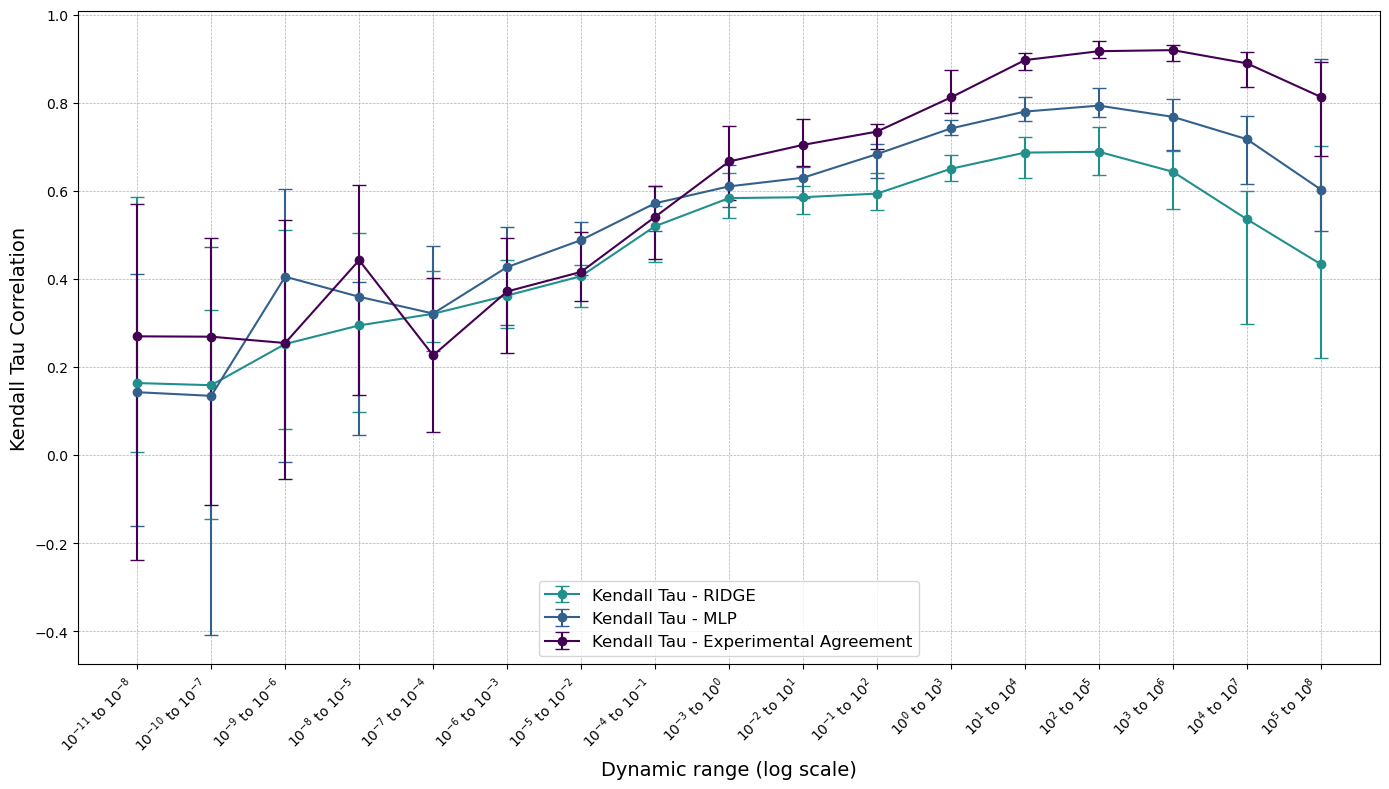

In [262]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
combined_df['Range Start'] = combined_df['Range'].apply(lambda x: int(x.split(' to ')[0]))
combined_df['Range End'] = combined_df['Range'].apply(lambda x: int(x.split(' to ')[1]))
#drop those with Range start value counts < max value count
max_range_start_value_count = combined_df['Range Start'].value_counts().max()
range_start_value_counts = combined_df['Range Start'].value_counts()
range_start_value_counts = range_start_value_counts[range_start_value_counts == max_range_start_value_count]
combined_df = combined_df[combined_df['Range Start'].isin(range_start_value_counts.index)]

# Sort the DataFrame by the numeric start of the range
combined_df.sort_values(by='Range Start', inplace=True)

#drop nans
combined_df = combined_df.dropna()

# Filter the combined DataFrame for relevant metrics and sources
filtered_df = combined_df[
    (combined_df['Metric'] == 'Kendall Tau') &
    (combined_df['Model'].isin(['RIDGE', 'MLP', 'Experimental Agreement']))
]

# Set up colors
colors = cm.get_cmap('viridis', 256)
colors = colors(np.linspace(0, 1, 256))
colors = colors[:128][::-1]
c1, c2, c3 = colors[0], colors[50], colors[-1]  # Use distinct colors for each line

# Create the figure and axis
fig, ax1 = plt.subplots(figsize=(14, 8))

# Plot Kendall Tau for each source
sources = ['RIDGE', 'MLP', 'Experimental Agreement']
colors_map = [c1, c2, c3]
for source, color in zip(sources, colors_map):
    subset = filtered_df[filtered_df['Model'] == source]
    lb = subset['Median'] - subset['Lower']
    ub = subset['Upper'] - subset['Median']

    ax1.errorbar(
        subset['Range'], subset['Median'],
        yerr=[lb, ub],
        fmt='o-', capsize=5, color=color,
        label=f'Kendall Tau - {source}'
    )

# Customize the first axis
ax1.set_xlabel('Dynamic range (log scale)', fontsize=14)
ax1.set_ylabel('Kendall Tau Correlation', fontsize=14)
ax1.tick_params(axis='x', rotation=45)
ax1.grid(visible=True, linestyle='--', linewidth=0.5)

# Customize the x-tick labels if needed
log_ranges_lower = [int(r.split(' to ')[0]) for r in filtered_df['Range'].unique()]
log_ranges_upper = [int(r.split(' to ')[1]) for r in filtered_df['Range'].unique()]
xtick_labels = [f'$10^{{{lower}}}$ to $10^{{{upper}}}$' for lower, upper in zip(log_ranges_lower, log_ranges_upper)]

ax1.set_xticks(np.arange(len(log_ranges_lower)))
ax1.set_xticklabels(xtick_labels, rotation=45, ha='right')

# Combine and show legend
ax1.legend(loc='lower center', fontsize=12)

# Set a tight layout
plt.tight_layout()

# Save the plot
plt.savefig('kendall_tau_comparison.png', dpi=800)
#print x range, adjust it later
print(plt.gca().get_xlim())
# plt.xlim(3.5,16.5)
# Display the plot
plt.show()


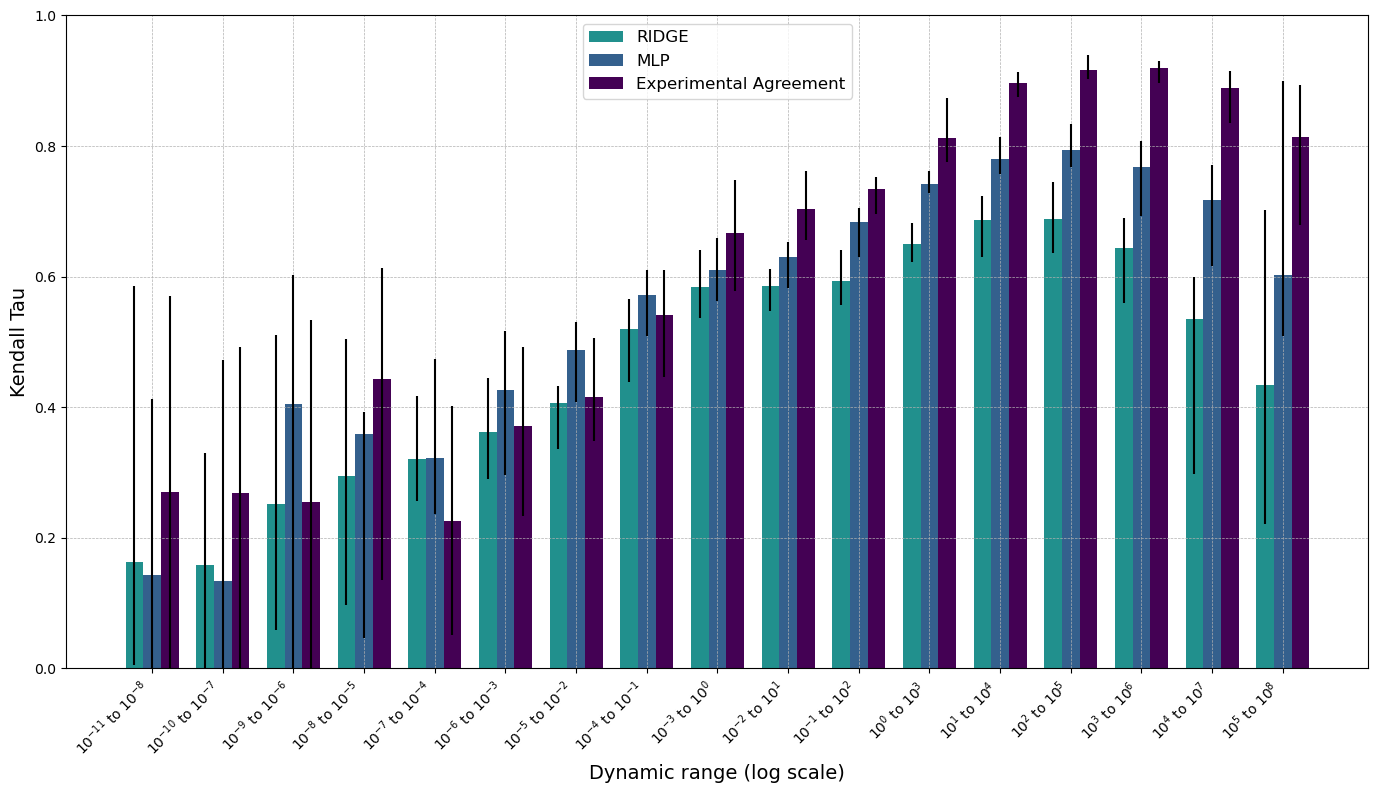

In [263]:
# Create the figure and axis
fig, ax = plt.subplots(figsize=(14, 8))

# Plot Kendall Tau for each source
sources = ['RIDGE', 'MLP', 'Experimental Agreement']
colors_map = [c1, c2, c3]

#set space between bars
bar_width = 0.25

#set position of bar on x axis
r1 = np.arange(len(filtered_df['Range'].unique()))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

for source, color, r in zip(sources, colors_map, [r1, r2, r3]):
    subset = filtered_df[filtered_df['Model'] == source]
    lb = subset['Median'] - subset['Lower']
    ub = subset['Upper'] - subset['Median']

    ax.bar(
        r, subset['Median'],
        yerr=[lb, ub],
        width=bar_width, color=color,
        label=f'Kendall Tau - {source}'
    )

# Customize the axis
ax.set_xlabel('Dynamic range (log scale)', fontsize=14)
ax.set_ylabel('Kendall Tau' , fontsize=14)
ax.set_xticks([r + bar_width for r in range(len(filtered_df['Range'].unique()))])
ax.set_xticklabels(xtick_labels, rotation=45, ha='right')
ax.grid(visible=True, linestyle='--', linewidth=0.5)

# Combine and show legend
ax.legend(loc='upper center', fontsize=12)
#remove Kendall Tau -  from legend strings
handles, labels = ax.get_legend_handles_labels()
labels = [label.replace('Kendall Tau - ', '') for label in labels]
ax.legend(handles, labels, loc='upper center', fontsize=12)


# Set a tight layout
plt.tight_layout()

# plt.xlim(3.7,16.8)
plt.ylim(0,1)
# Display the plot
#save
plt.savefig('kendall_tau_comparison_bars.png', dpi=800)
plt.show()


2 2 2


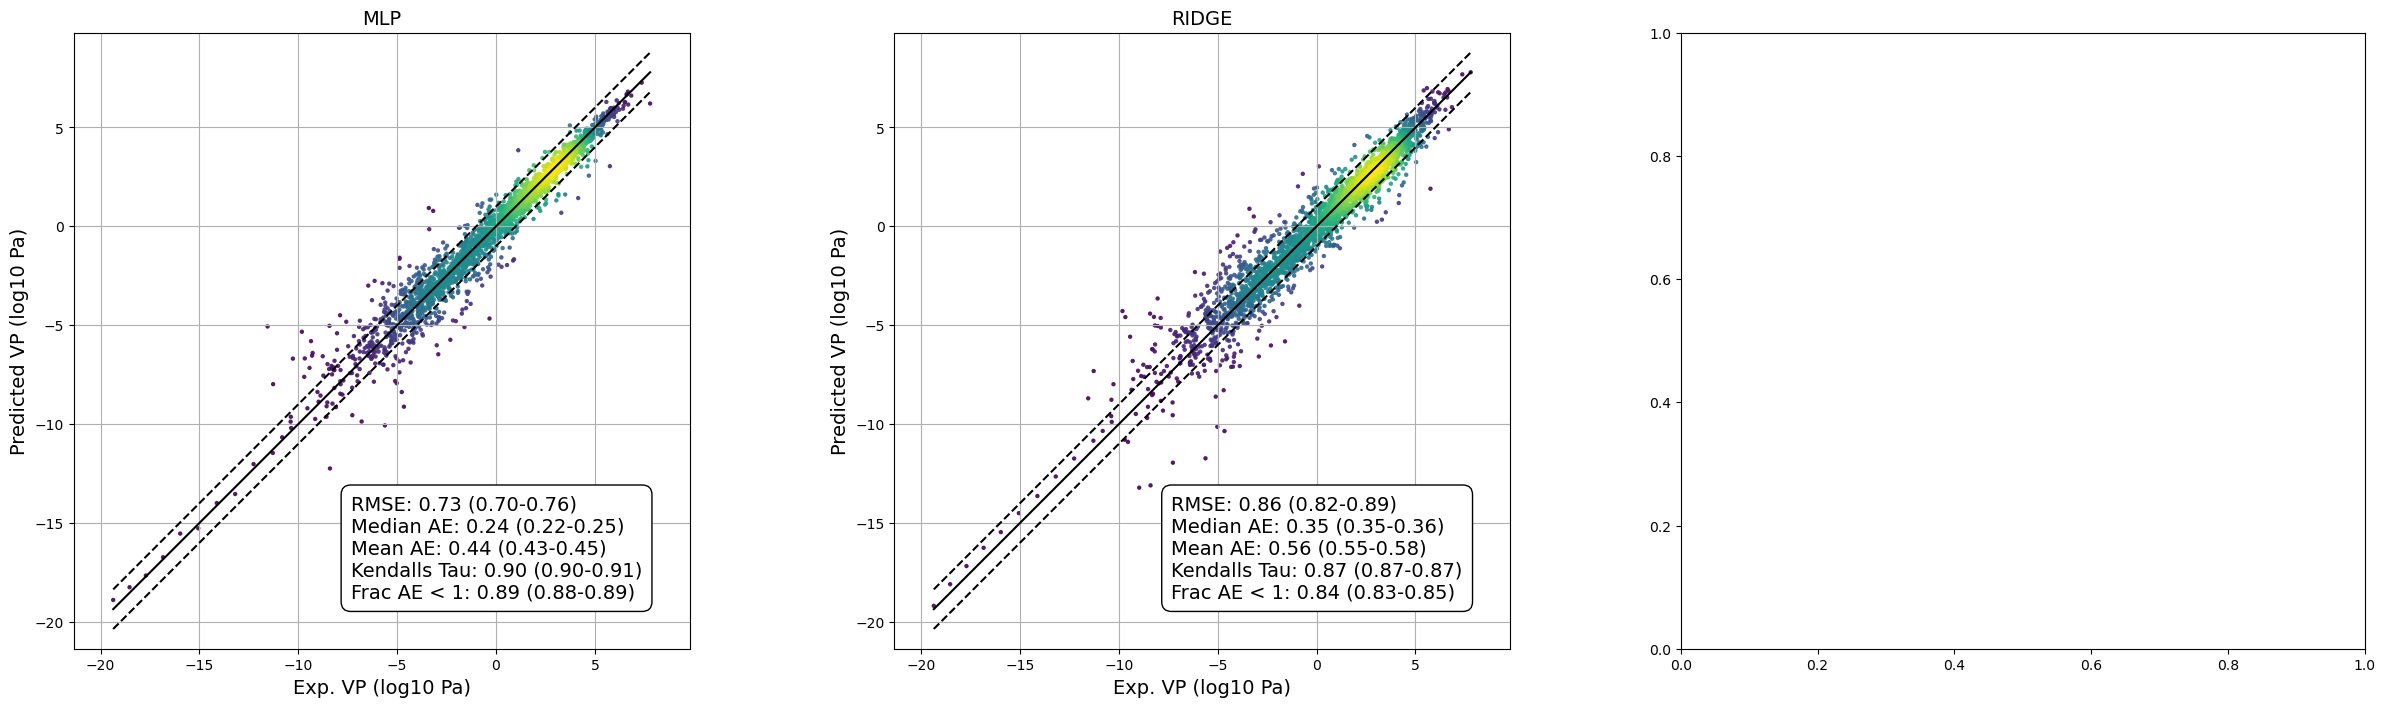

In [264]:
descriptor = 'RDKit_PhysChem'
pred_lol = []
for model_name in models:
    pred_lol.append(preds_list[descriptor][model_name])
reals_lol = [reals_list] * len(models)
molregnos = data_test['molregnos_list']
molregnos = [molregnos] * len(models)
print(len(reals_lol),len(pred_lol),len(molregnos))
from utils.visualization import density_plots
density_plots(reals_list=reals_lol, predictions_list=pred_lol, title=models, molregnos_list=molregnos)


10 10 10 10 10 10


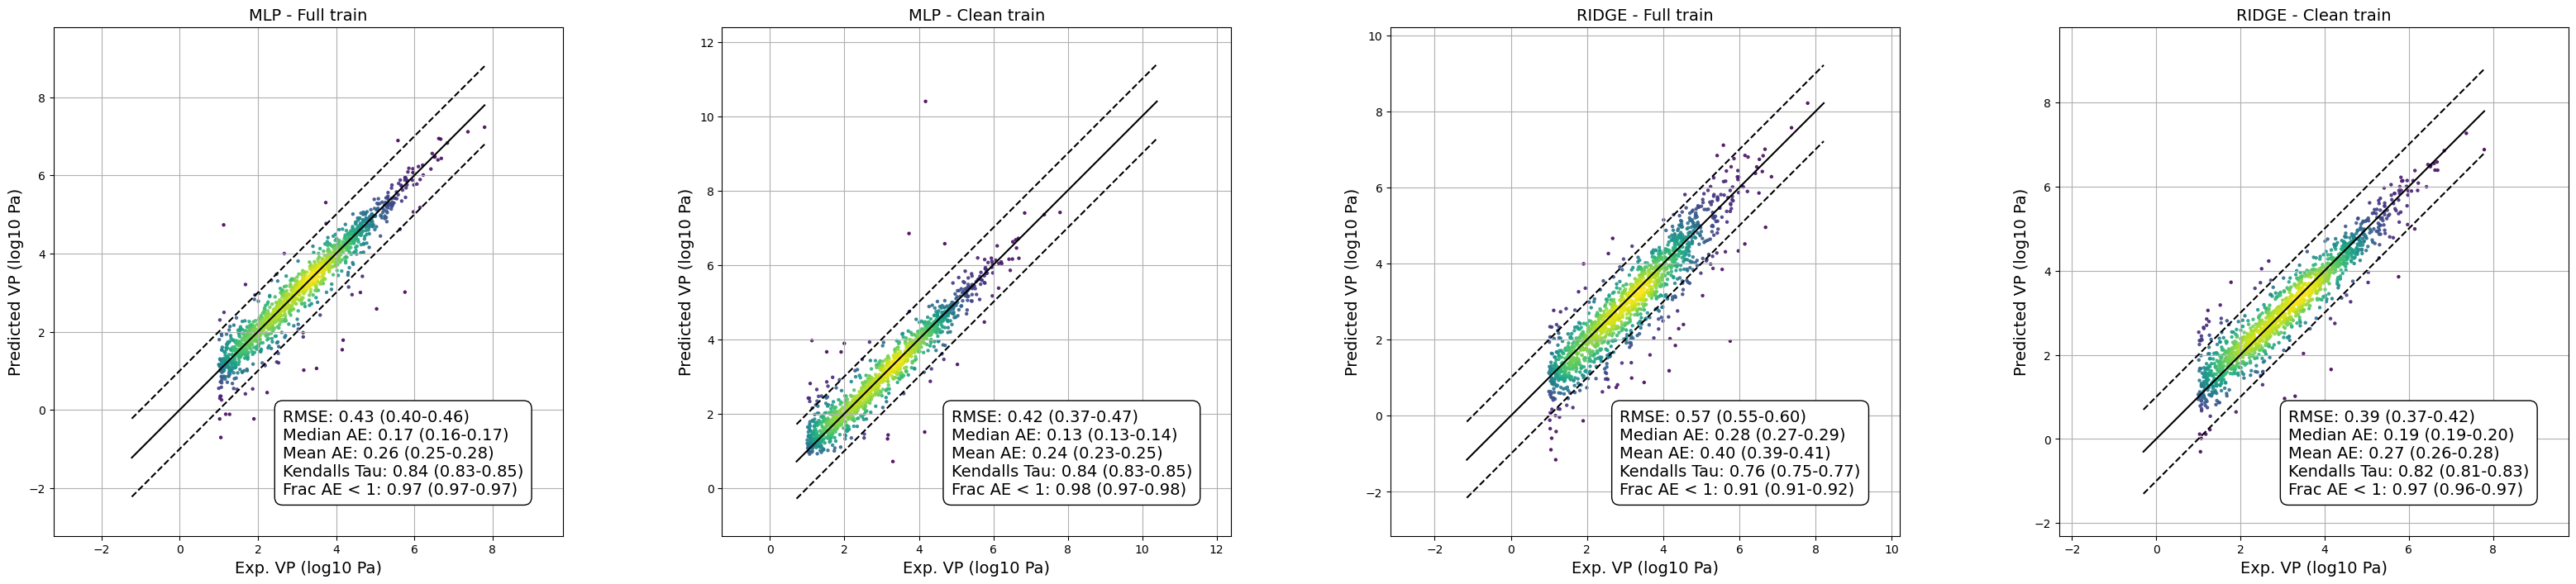

In [265]:

data_different_ranges = pd.read_pickle('results/test_set_results_physchem.pkl')

reals_list = data_different_ranges['reals_list']
preds_trained_mid = data_different_ranges['predictions_train_mid_range']
pred_train_full = data_different_ranges['predictions_train_full_range']
preds_trained_mid_mlp = preds_trained_mid['RDKit_PhysChem', 'MLP']
preds_trained_mid_ridge = preds_trained_mid['RDKit_PhysChem', 'RIDGE']
pred_train_full_mlp = pred_train_full['RDKit_PhysChem', 'MLP']
pred_train_full_ridge = pred_train_full['RDKit_PhysChem', 'RIDGE']
molregnos = data_different_ranges['molregnos_list']
print(len(reals_list),len(preds_trained_mid_mlp),len(preds_trained_mid_ridge),len(pred_train_full_mlp),len(pred_train_full_ridge),len(molregnos))
reals_lol = [reals_list] * 4
pred_lol = [preds_trained_mid_mlp, preds_trained_mid_ridge, pred_train_full_mlp, pred_train_full_ridge]
molregnos = [molregnos] * 4
titles = ['MLP - Clean train', 'RIDGE - Clean train', 'MLP - Full train', 'RIDGE - Full train']
#change order of all to be: mlp full - mlp clean - ridge full - ridge clean
pred_lol = [pred_train_full_mlp, preds_trained_mid_mlp, pred_train_full_ridge, preds_trained_mid_ridge]
titles = ['MLP - Full train', 'MLP - Clean train', 'RIDGE - Full train', 'RIDGE - Clean train']
density_plots(reals_list=reals_lol, predictions_list=pred_lol, title=titles, molregnos_list=molregnos,dims=(1,4))

In [266]:
from utils.stats import get_stats
import scipy.stats as stats
from scipy.stats import t  #

def compile_metrics_dataframe(
    data_path,
    thresholds=[1],
    statistic_names=['RMSE', 'MAE', 'KendallTau', 'MedianAE', 'Error_below_1'],
    train_set='full_range'
):
    """
    Compile a DataFrame with the mean and 90% confidence intervals for specified metrics.

    Parameters:
    - data_path (str): Path to the pickled data file.
    - thresholds (list): List of thresholds for calculating error fractions.
    - statistic_names (list): List of metric names to include.
    - train_set (str): Specifies which dataset to use ('full_range' or 'mid_range').

    Returns:
    - pd.DataFrame: A DataFrame with metrics, means, and confidence intervals.
    """
    # Load the saved data
    data = pd.read_pickle(data_path)

    # Adjust to the new data structure
    if train_set == 'full_range':
        predictions_list = data['predictions_train_full_range']
    elif train_set == 'mid_range':
        predictions_list = data['predictions_train_mid_range']
    else:
        raise ValueError(f"Unknown train_set value: {train_set}")

    reals_list = data['reals_list']
    combined_titles = list(predictions_list.keys())  # Adjusted to use keys if structured as a dictionary.

    # Initialize a dictionary to hold metric data
    all_stats = {stat: [] for stat in statistic_names}

    # Loop through combinations
    for title in combined_titles:
        if isinstance(title, tuple):  # Check if `title` is a tuple
            descriptor_name, model_name = title
        else:  # Assume it's a string
            descriptor_name, model_name = title.split(' (')[0], title.split(' (')[1].rstrip(')')

        real_values = reals_list
        pred_values = predictions_list[title]
        metric_data = {stat: [] for stat in statistic_names}

        for real, pred in zip(real_values, pred_values):
            stat_dict = get_stats(real, pred, thresholds)
            for stat in statistic_names:
                metric_data[stat].append(stat_dict[stat])

        # Append statistics for each title
        for stat in statistic_names:
            mean_val = np.mean(metric_data[stat])
            ci_low, ci_high = t.interval(
                0.90, len(metric_data[stat]) - 1, loc=mean_val, scale=stats.sem(metric_data[stat])
            )
            all_stats[stat].append({
                'Model': model_name,
                'Descriptor': descriptor_name,
                'Mean': mean_val,
                'CI_Low': ci_low,
                'CI_High': ci_high
            })


    # Convert to a DataFrame
    df_list = []
    for stat, stat_data in all_stats.items():
        df = pd.DataFrame(stat_data)
        df['Metric'] = stat
        df_list.append(df)

    # Combine all metrics into a single DataFrame
    combined_df = pd.concat(df_list, ignore_index=True)
    combined_df = combined_df[['Model', 'Descriptor', 'Metric', 'Mean', 'CI_Low', 'CI_High']]

    # Sort for better readability
    combined_df = combined_df.sort_values(['Descriptor', 'Model', 'Metric']).reset_index(drop=True)

    return combined_df


In [267]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def plot_kendall_tau_heatmaps_with_difference(df1, df2, title1=' Heatmap (Full Range)', 
                                              title2=' Heatmap (Mid Range)', 
                                              diff_title='Difference (Full - Mid Range)',metric = 'KendallTau',model_order = ['MLP', 'XGB', 'RF', 'RF_SHORT', 'RIDGE'],descriptor_order = ['mfp3', 'RDKit_PhysChem', 'mfp0'],filename=None):
    """
    Plot two heatmaps for Kendall Tau values with confidence intervals side-by-side, 
    and a third heatmap showing the differences between the two.

    Parameters:
    df1 (pd.DataFrame): DataFrame for the first heatmap with columns ['Model', 'Descriptor', 'Metric', 'Mean', 'CI_Low', 'CI_High']
    df2 (pd.DataFrame): DataFrame for the second heatmap with columns ['Model', 'Descriptor', 'Metric', 'Mean', 'CI_Low', 'CI_High']
    title1 (str): Title of the first heatmap
    title2 (str): Title of the second heatmap
    diff_title (str): Title of the difference heatmap
    """
    # Define model and descriptor orders for sorting
    title1 = metric + title1
    title2 = metric + title2
    df1 = df1[df1['Metric'] == metric]
    df2 = df2[df2['Metric'] == metric]

    # Filter for Kendall Tau metric and prepare DataFrames
    for df in [df1, df2]:
        df['Model'] = pd.Categorical(df['Model'], categories=model_order, ordered=True)
        df['Descriptor'] = pd.Categorical(df['Descriptor'], categories=descriptor_order, ordered=True)
    
    df1 = df1[df1['Metric'] == metric].sort_values(['Descriptor', 'Model'])
    df2 = df2[df2['Metric'] == metric].sort_values(['Descriptor', 'Model'])

    heatmap_data1 = df1.pivot(index='Descriptor', columns='Model', values='Mean')
    heatmap_data2 = df2.pivot(index='Descriptor', columns='Model', values='Mean')

    # Calculate the difference between the two heatmaps
    heatmap_diff = heatmap_data1 - heatmap_data2

    # Get the maximum absolute difference for symmetric color scaling
    max_diff = np.max(np.abs(heatmap_diff.values))

    # Create subplots
    fig, axes = plt.subplots(1, 3, figsize=(36, 10))

    # Plot first heatmap
    sns.heatmap(heatmap_data1, annot=False, cmap='coolwarm', fmt=".2f", linewidths=0.5, cbar=True, ax=axes[0])
    axes[0].set_title(title1, fontsize=14)
    axes[0].set_xlabel('Model')
    axes[0].set_ylabel('Descriptor')
    axes[0].tick_params(axis='x', rotation=45, labelsize=14)
    axes[0].tick_params(axis='y', rotation=45, labelsize=14)

    # Add text annotations for mean and CI to the first heatmap
    for i in range(heatmap_data1.shape[0]):
        for j in range(heatmap_data1.shape[1]):
            mean_val = heatmap_data1.iloc[i, j]
            if not pd.isnull(mean_val):
                ci_low = df1[
                    (df1['Descriptor'] == heatmap_data1.index[i]) &
                    (df1['Model'] == heatmap_data1.columns[j])
                ]['CI_Low'].values[0]
                ci_high = df1[
                    (df1['Descriptor'] == heatmap_data1.index[i]) &
                    (df1['Model'] == heatmap_data1.columns[j])
                ]['CI_High'].values[0]
                annotation_text = f"{mean_val:.2f}\n({ci_low:.2f}-{ci_high:.2f})"
                axes[0].text(j + 0.5, i + 0.5, annotation_text, ha='center', va='center', color='black', fontsize=14)

    # Plot second heatmap
    sns.heatmap(heatmap_data2, annot=False, cmap='coolwarm', fmt=".2f", linewidths=0.5, cbar=True, ax=axes[1])
    axes[1].set_title(title2, fontsize=14)
    axes[1].set_xlabel('Model')
    axes[1].set_ylabel('Descriptor')
    axes[1].tick_params(axis='x', rotation=45, labelsize=14)
    axes[1].tick_params(axis='y', rotation=45, labelsize=14)

    # Add text annotations for mean and CI to the second heatmap
    for i in range(heatmap_data2.shape[0]):
        for j in range(heatmap_data2.shape[1]):
            mean_val = heatmap_data2.iloc[i, j]
            if not pd.isnull(mean_val):
                ci_low = df2[
                    (df2['Descriptor'] == heatmap_data2.index[i]) &
                    (df2['Model'] == heatmap_data2.columns[j])
                ]['CI_Low'].values[0]
                ci_high = df2[
                    (df2['Descriptor'] == heatmap_data2.index[i]) &
                    (df2['Model'] == heatmap_data2.columns[j])
                ]['CI_High'].values[0]
                annotation_text = f"{mean_val:.2f}\n({ci_low:.2f}-{ci_high:.2f})"
                axes[1].text(j + 0.5, i + 0.5, annotation_text, ha='center', va='center', color='black', fontsize=14)

    # Plot difference heatmap with centered color scale at 0
    sns.heatmap(heatmap_diff, annot=True, cmap='coolwarm', vmin=-max_diff, vmax=max_diff, center=0,
                fmt=".2f", linewidths=0.5, cbar=True, ax=axes[2], annot_kws={"fontsize": 14})
    axes[2].set_title(diff_title, fontsize=14)
    axes[2].set_xlabel('Model')
    axes[2].set_ylabel('Descriptor')
    axes[2].tick_params(axis='x', rotation=45, labelsize=14)
    axes[2].tick_params(axis='y', rotation=45, labelsize=14)

    plt.tight_layout()
    if filename:
        plt.savefig(filename + '.png', dpi = 800)
    plt.show()

    return heatmap_data1, heatmap_data2, heatmap_diff

/tmp/ipykernel_1070192/1203968848.py:28: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_1070192/1203968848.py:29: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



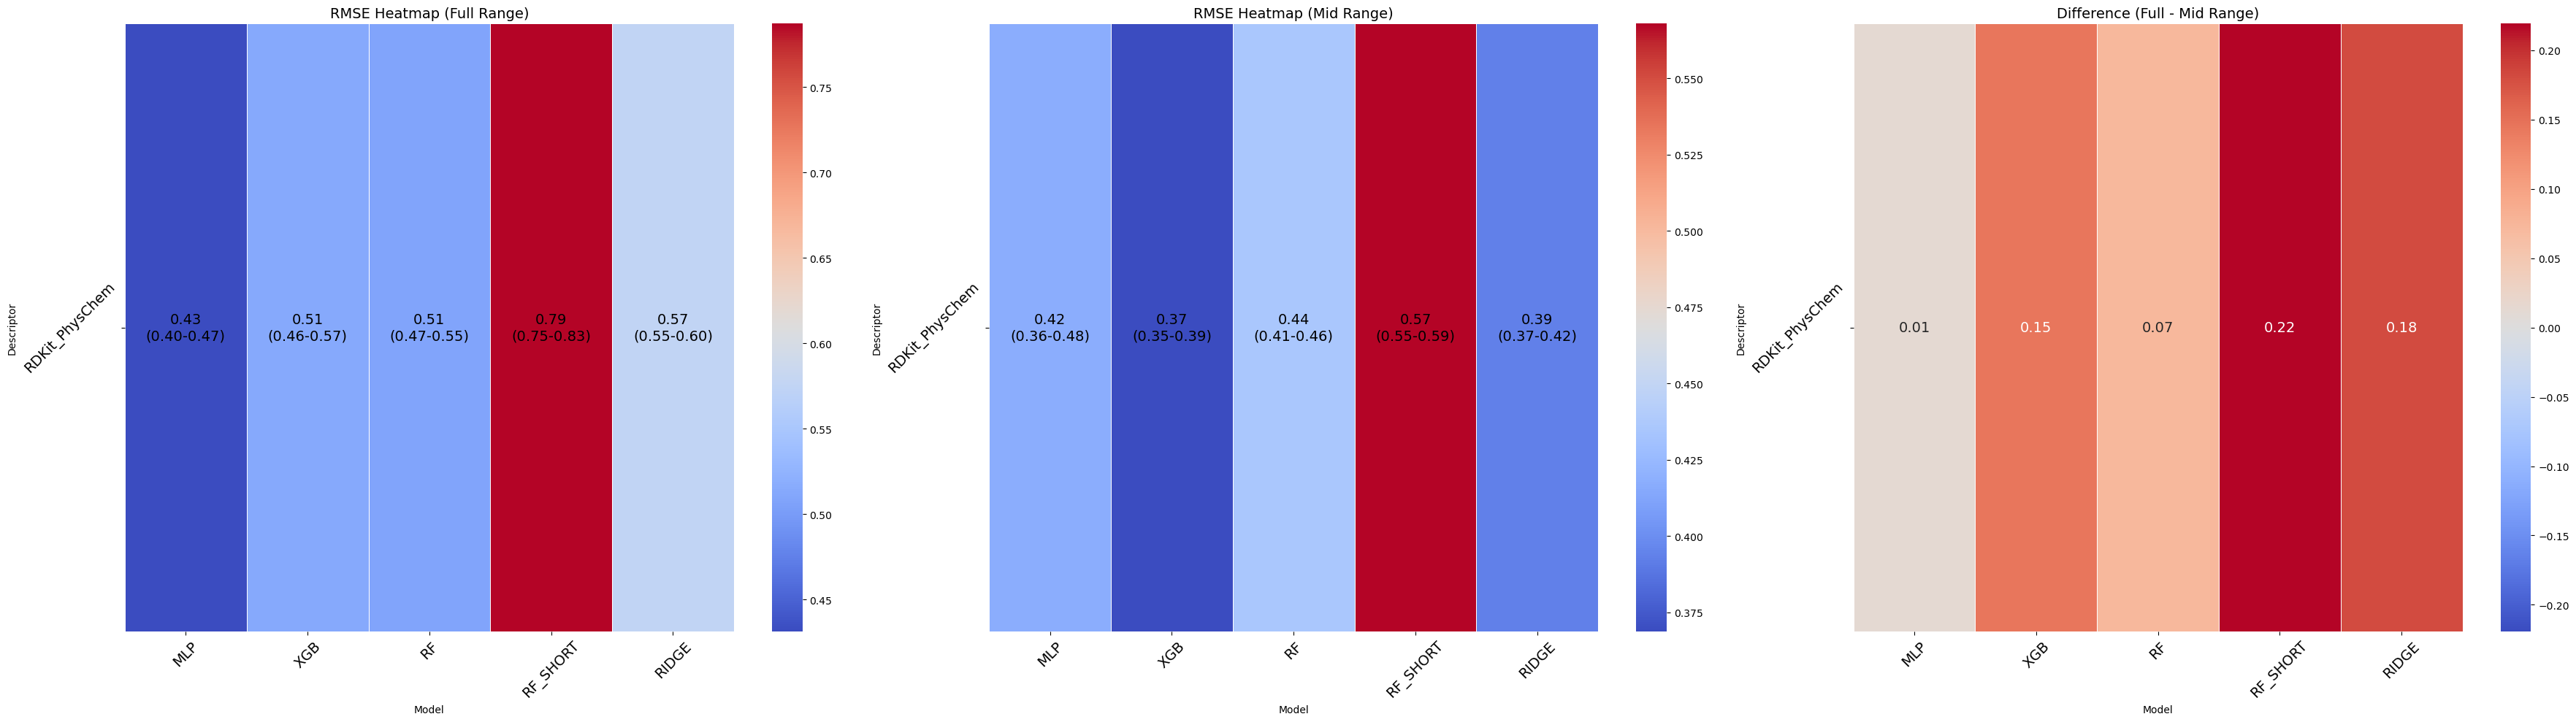

In [268]:
data_path = 'results/test_set_results_physchem.pkl'
df_metrics_full_train_range_counts_and_physchem = compile_metrics_dataframe(data_path,train_set='full_range')
df_metrics_full_mid_range_counts_and_physchem = compile_metrics_dataframe(data_path,train_set='mid_range')
heatmap_data1, heatmap_data2, heatmap_diff =plot_kendall_tau_heatmaps_with_difference(df_metrics_full_train_range_counts_and_physchem, df_metrics_full_mid_range_counts_and_physchem, metric='RMSE',descriptor_order=['RDKit_PhysChem', 'Counts'],filename='test_set_overfitting_check_different_train_ranges_Counts_NeuralNetworkModelGregstyle_RMSE')

/tmp/ipykernel_1070192/2366031085.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_1070192/2366031085.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_1070192/1203968848.py:28: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipyk

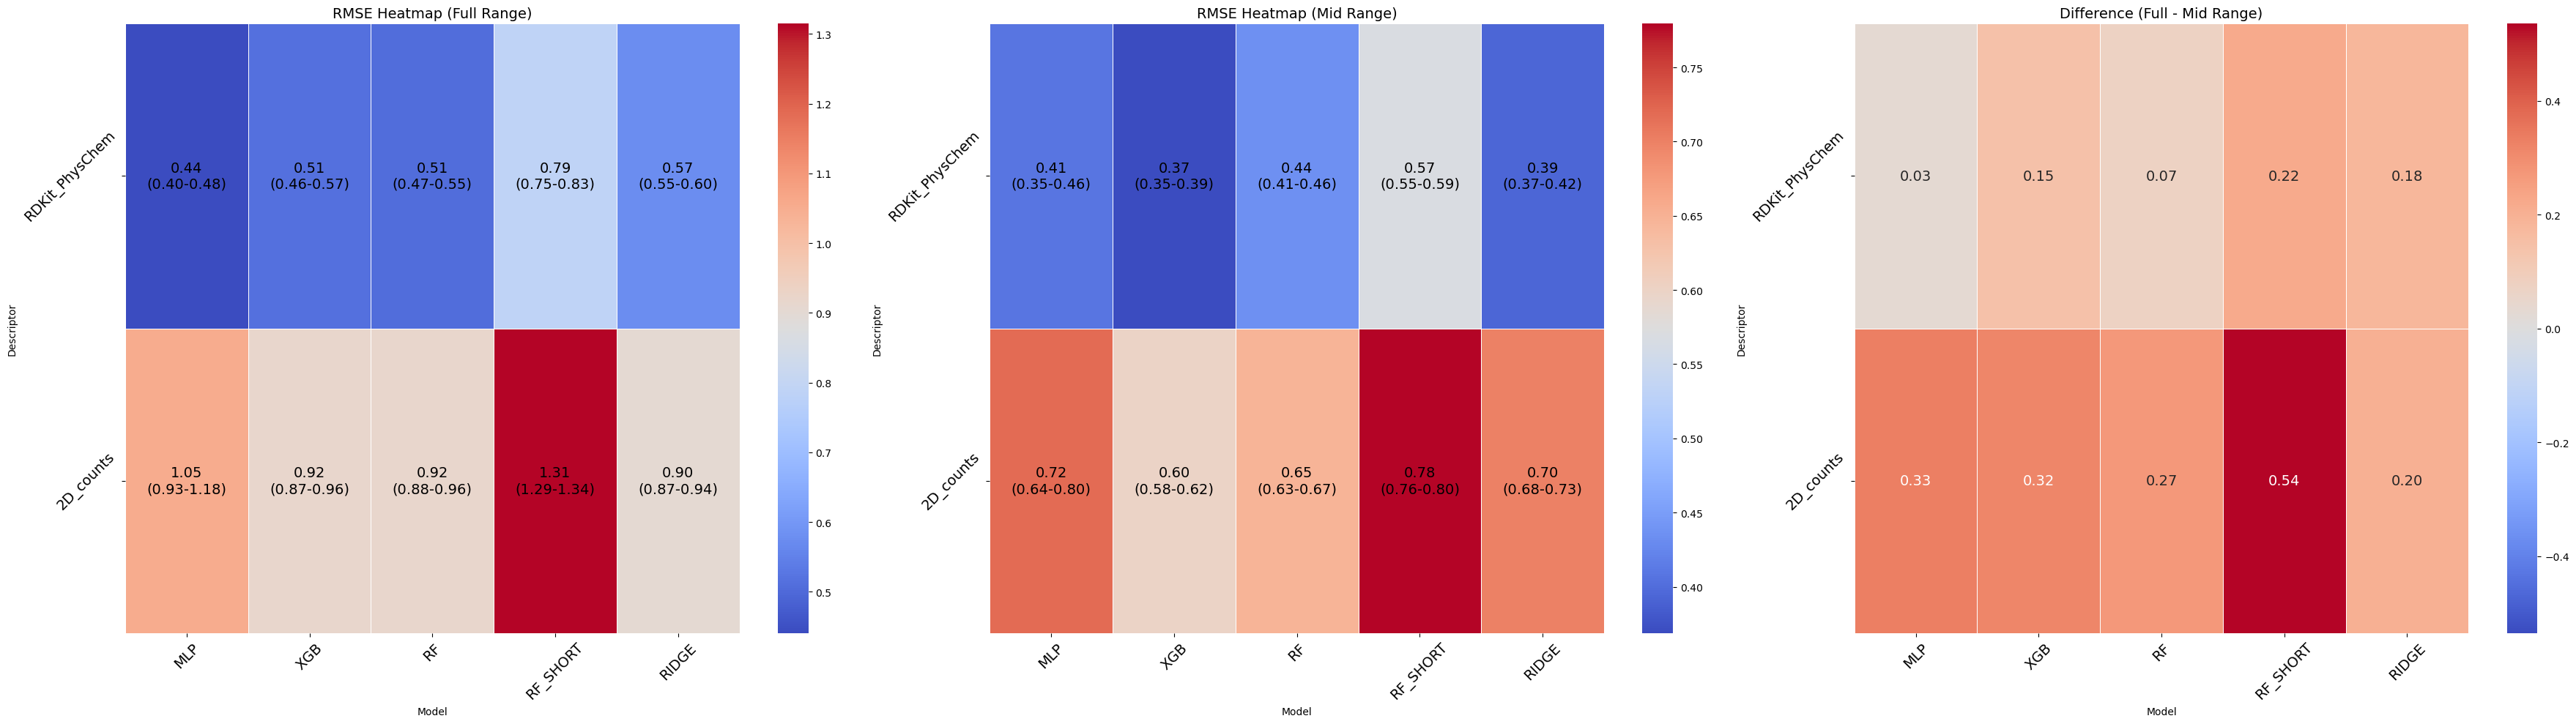

/tmp/ipykernel_1070192/1203968848.py:28: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_1070192/1203968848.py:29: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



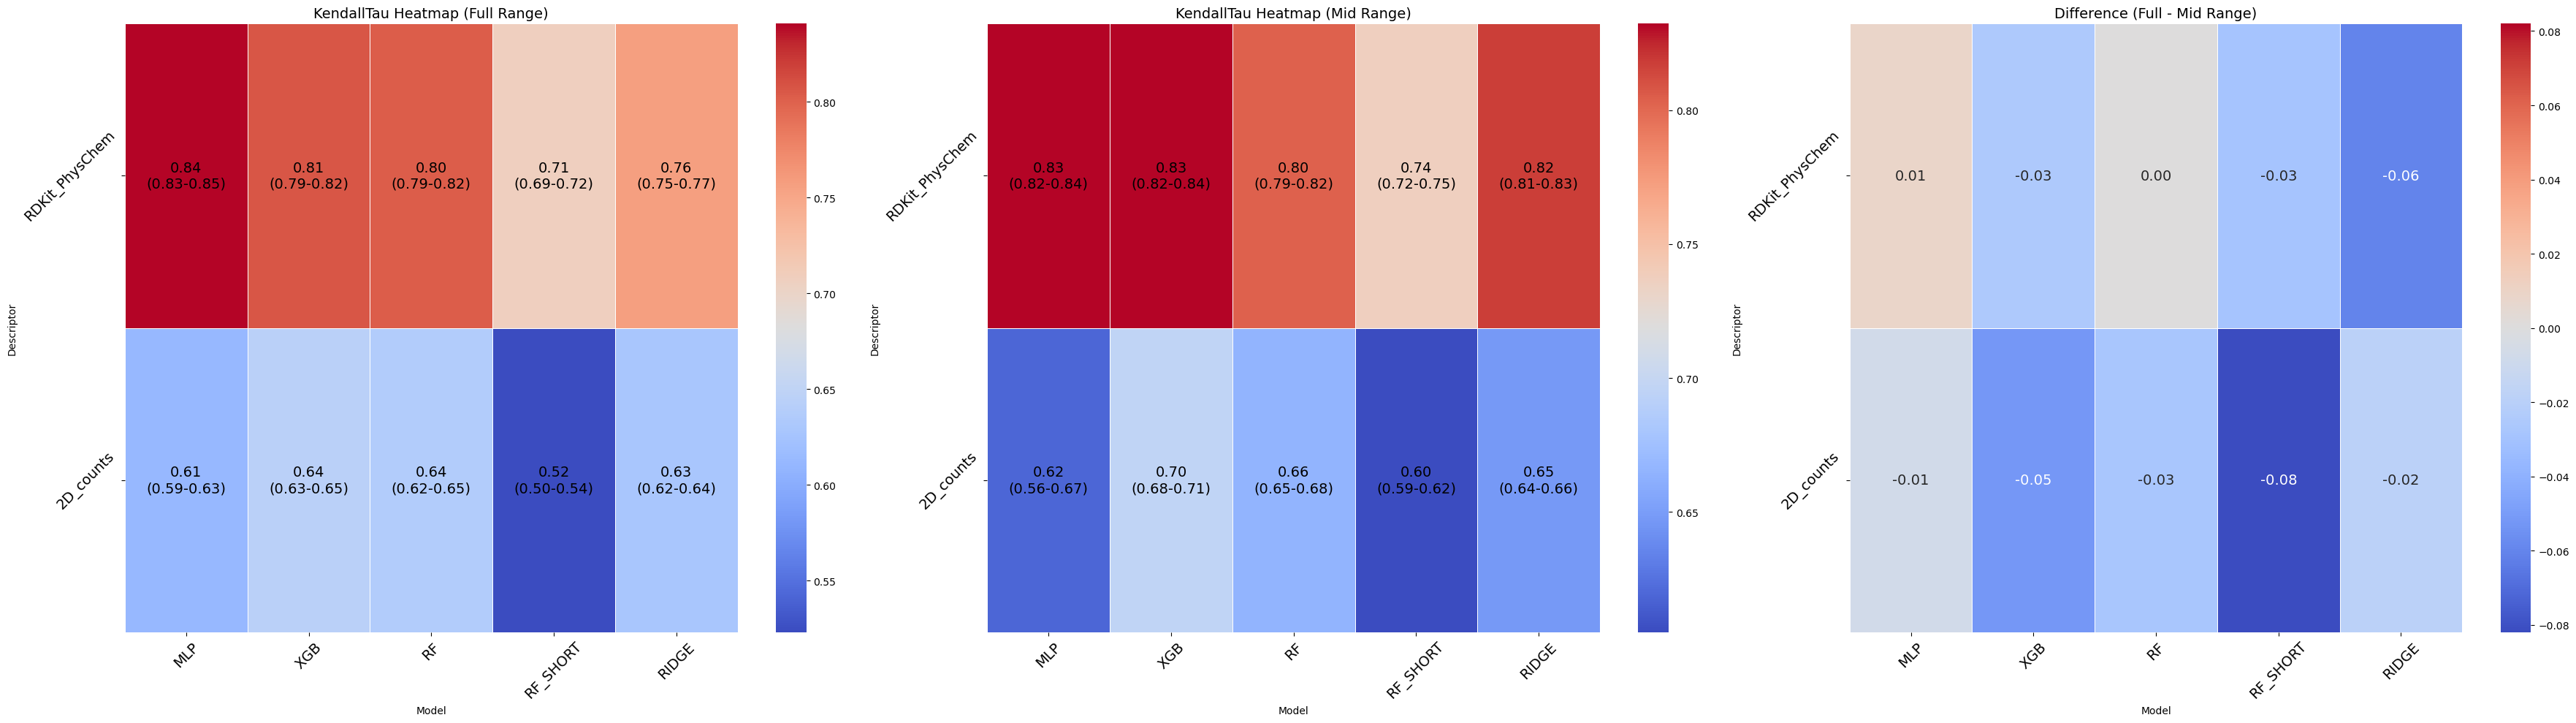

In [269]:
data_path = 'results/test_set_results_physchem_MDFP_2D_counts.pkl'
df_metrics_full_train_range_counts_and_physchem = compile_metrics_dataframe(data_path,train_set='full_range')
df_metrics_full_mid_range_counts_and_physchem = compile_metrics_dataframe(data_path,train_set='mid_range')
df_metrics_full_train_range_counts_and_physchem_no_mdfp = df_metrics_full_train_range_counts_and_physchem[df_metrics_full_train_range_counts_and_physchem['Descriptor'] != 'MDFP']
df_metrics_full_mid_range_counts_and_physchem_no_mdfp = df_metrics_full_mid_range_counts_and_physchem[df_metrics_full_mid_range_counts_and_physchem['Descriptor'] != 'MDFP']
#rename MDFP_2D_counts to 2D_counts
df_metrics_full_train_range_counts_and_physchem_no_mdfp['Descriptor'] = df_metrics_full_train_range_counts_and_physchem_no_mdfp['Descriptor'].replace({'MDFP_2D_counts': '2D_counts'})
df_metrics_full_mid_range_counts_and_physchem_no_mdfp['Descriptor'] = df_metrics_full_mid_range_counts_and_physchem_no_mdfp['Descriptor'].replace({'MDFP_2D_counts': '2D_counts'})
heatmap_data1, heatmap_data2, heatmap_diff = plot_kendall_tau_heatmaps_with_difference(df_metrics_full_train_range_counts_and_physchem_no_mdfp, df_metrics_full_mid_range_counts_and_physchem_no_mdfp, metric='RMSE',descriptor_order=['RDKit_PhysChem', '2D_counts'])
heatmap_data1, heatmap_data2, heatmap_diff = plot_kendall_tau_heatmaps_with_difference(df_metrics_full_train_range_counts_and_physchem_no_mdfp, df_metrics_full_mid_range_counts_and_physchem_no_mdfp, metric='KendallTau',descriptor_order=['RDKit_PhysChem', '2D_counts'])

/tmp/ipykernel_1070192/1203968848.py:28: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_1070192/1203968848.py:29: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



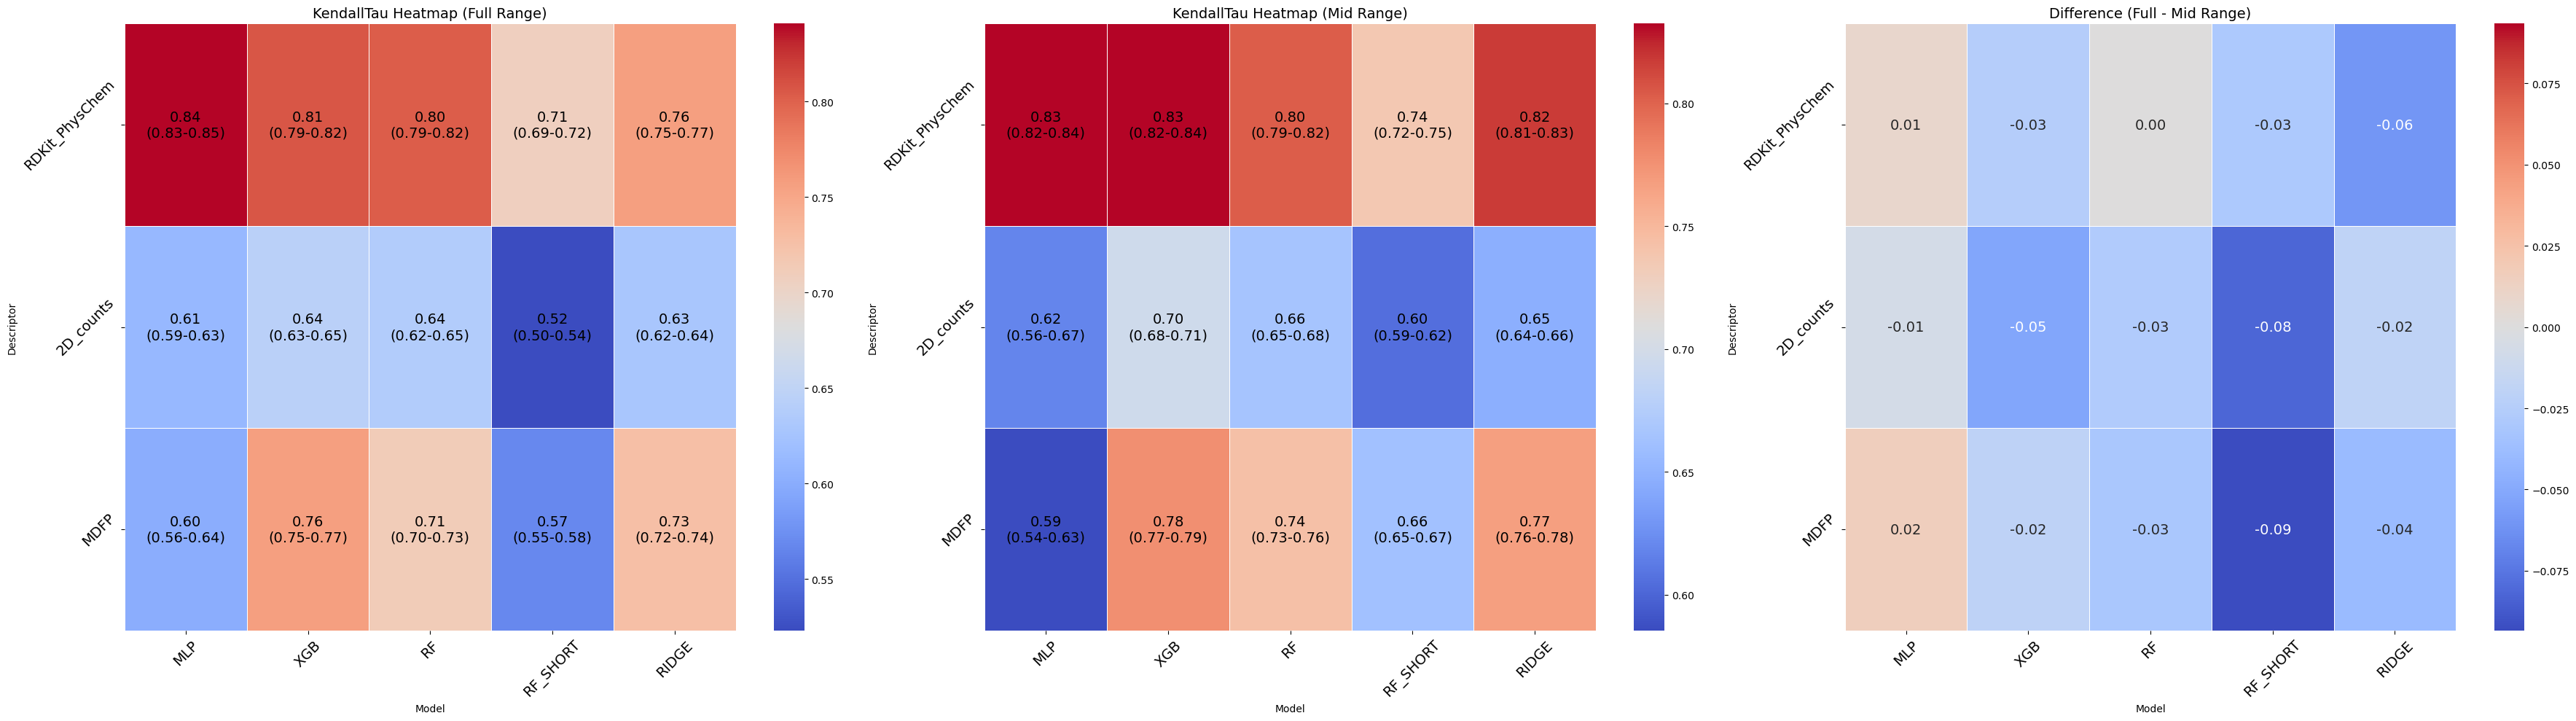

/tmp/ipykernel_1070192/1203968848.py:28: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_1070192/1203968848.py:29: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



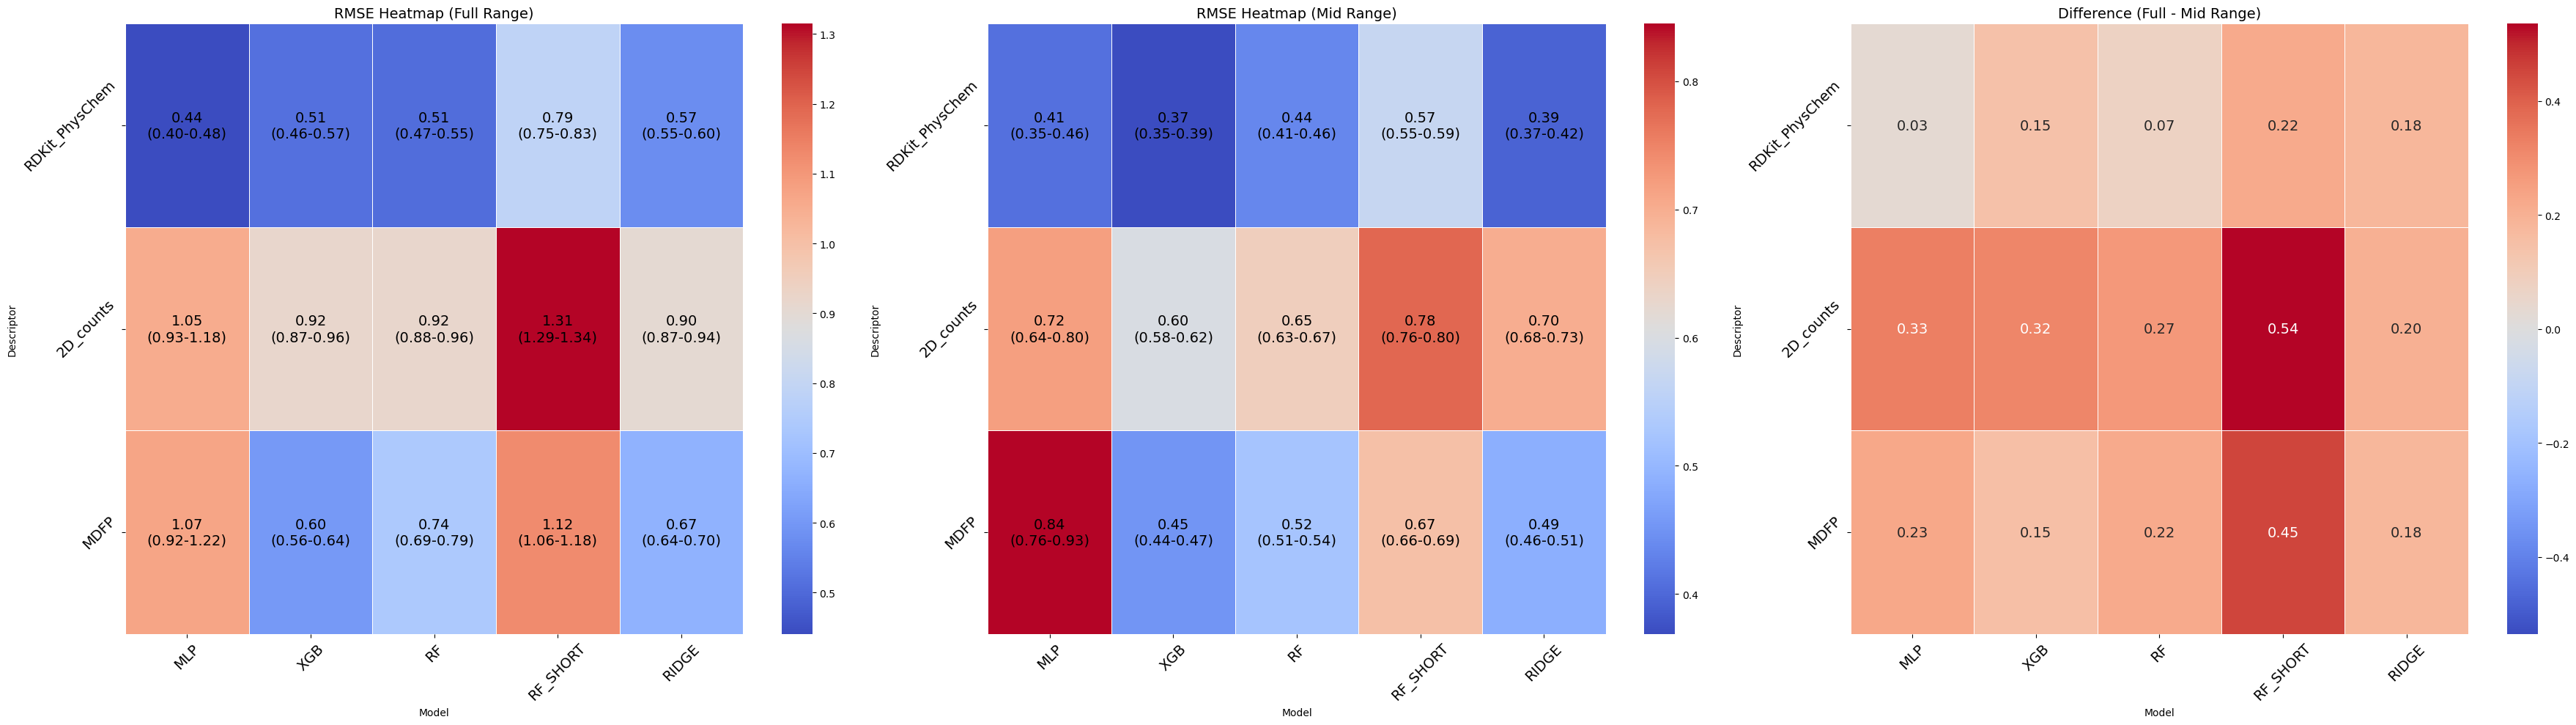

In [270]:
df_metrics_full_train_range_counts_and_physchem['Descriptor'] = df_metrics_full_train_range_counts_and_physchem['Descriptor'].replace({'MDFP_2D_counts': '2D_counts'})
df_metrics_full_mid_range_counts_and_physchem['Descriptor'] = df_metrics_full_mid_range_counts_and_physchem['Descriptor'].replace({'MDFP_2D_counts': '2D_counts'})

heatmap_data1, heatmap_data2, heatmap_diff = plot_kendall_tau_heatmaps_with_difference(df_metrics_full_train_range_counts_and_physchem, df_metrics_full_mid_range_counts_and_physchem, metric='KendallTau',descriptor_order=['RDKit_PhysChem', '2D_counts','MDFP'])
heatmap_data1, heatmap_data2, heatmap_diff = plot_kendall_tau_heatmaps_with_difference(df_metrics_full_train_range_counts_and_physchem, df_metrics_full_mid_range_counts_and_physchem, metric='RMSE',descriptor_order=['RDKit_PhysChem', '2D_counts','MDFP'])


/tmp/ipykernel_1070192/1203968848.py:28: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_1070192/1203968848.py:29: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



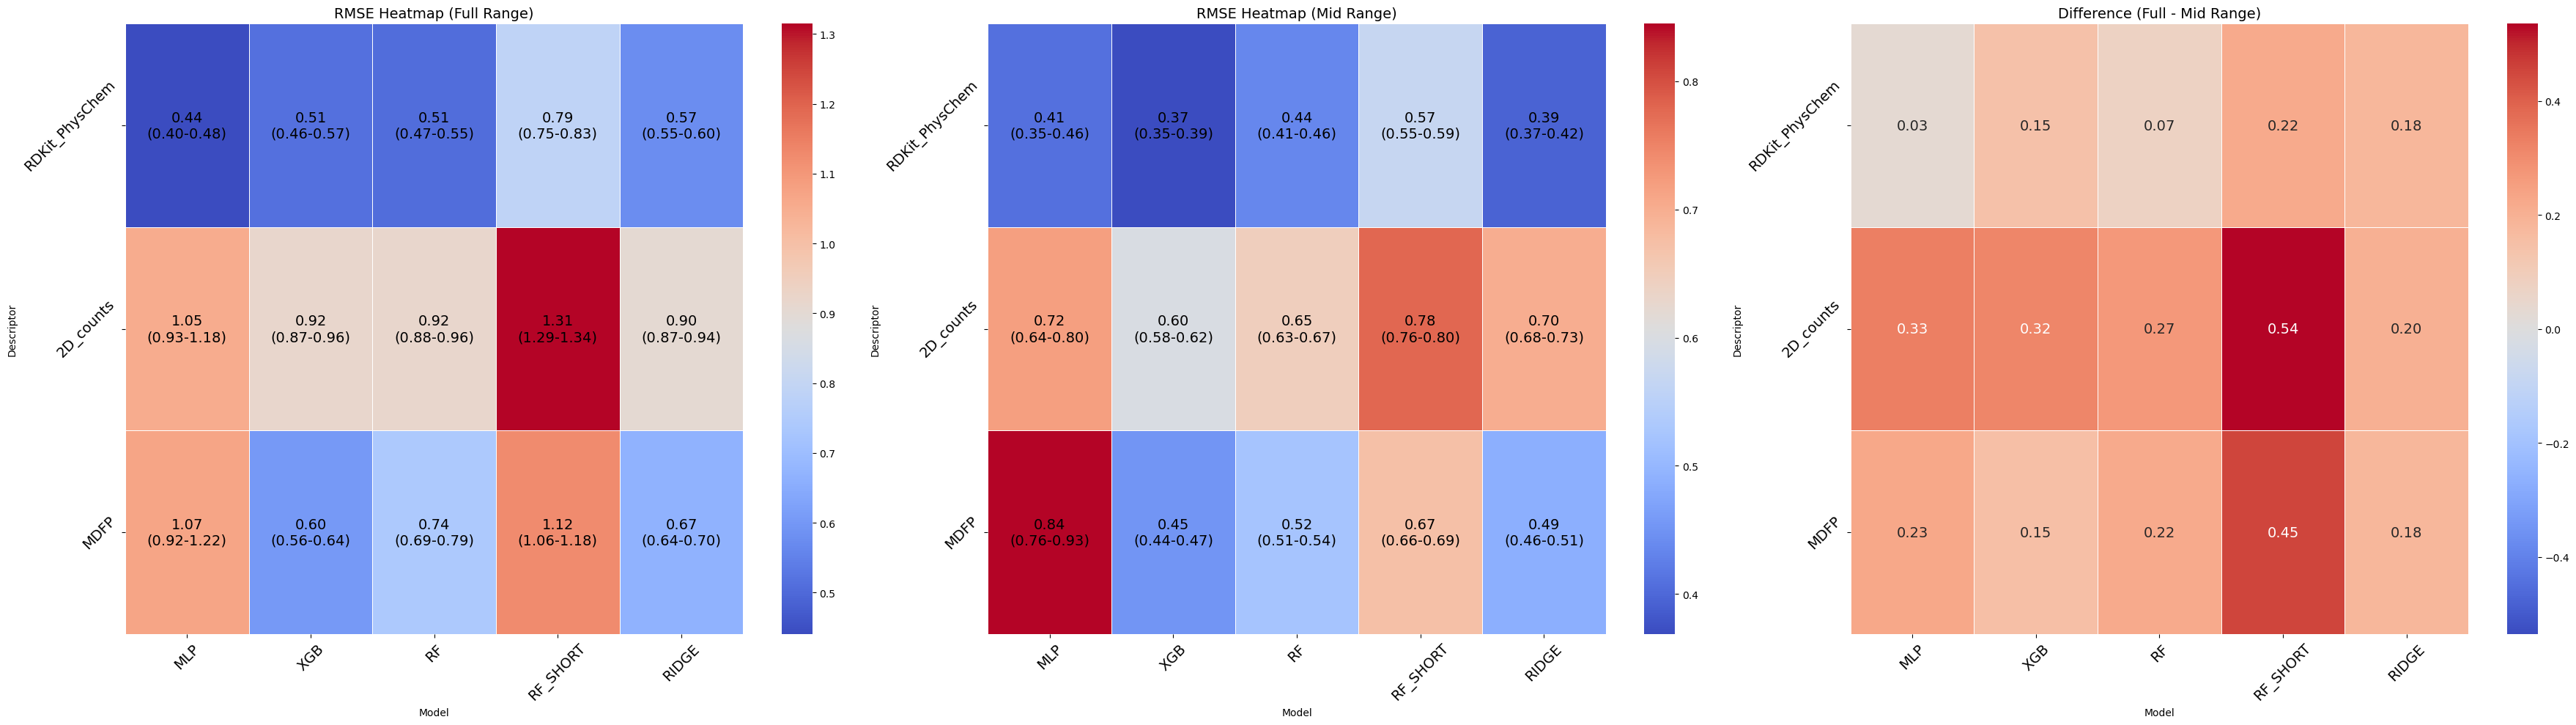

In [271]:
heatmap_data1, heatmap_data2, heatmap_diff = plot_kendall_tau_heatmaps_with_difference(df_metrics_full_train_range_counts_and_physchem, df_metrics_full_mid_range_counts_and_physchem, metric='RMSE',descriptor_order=['RDKit_PhysChem', '2D_counts','MDFP'])


Descriptor             MLP          RF   RF_SHORT      RIDGE         XGB
Model                                                                   
MDFP_2D_counts   72.010075  145.326089  84.161603  63.420153  100.515084
RDKit_PhysChem  143.983069  159.670782  71.910264  70.658076  238.261424
Descriptor             MLP          RF    RF_SHORT       RIDGE          XGB
Model                                                                      
MDFP_2D_counts  150.434851  228.189948  176.983065  130.159935   203.802620
RDKit_PhysChem  424.910117  305.843936  162.322298  167.364412  1123.411645


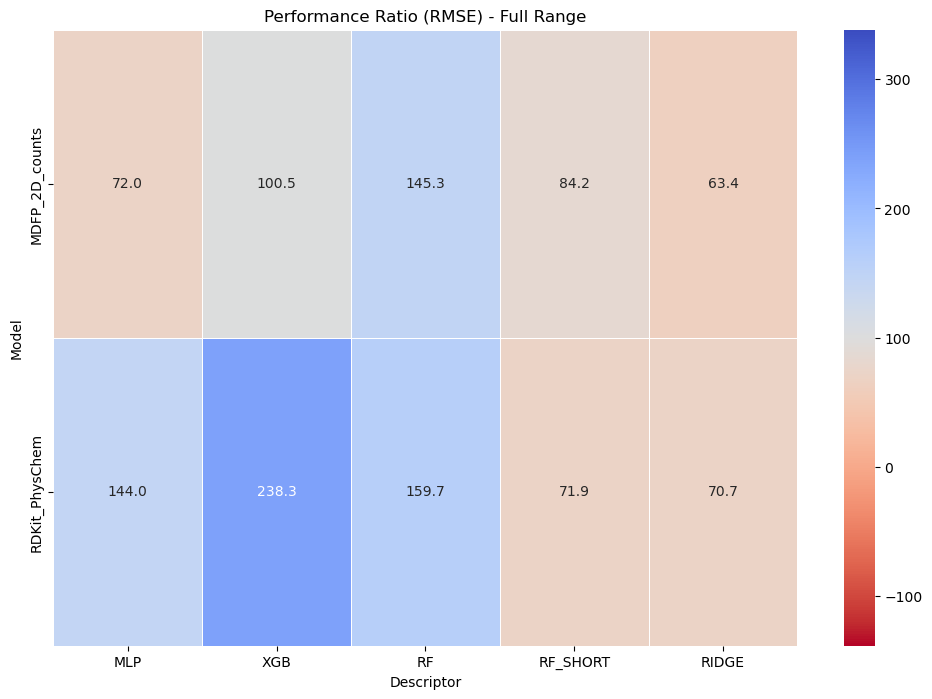

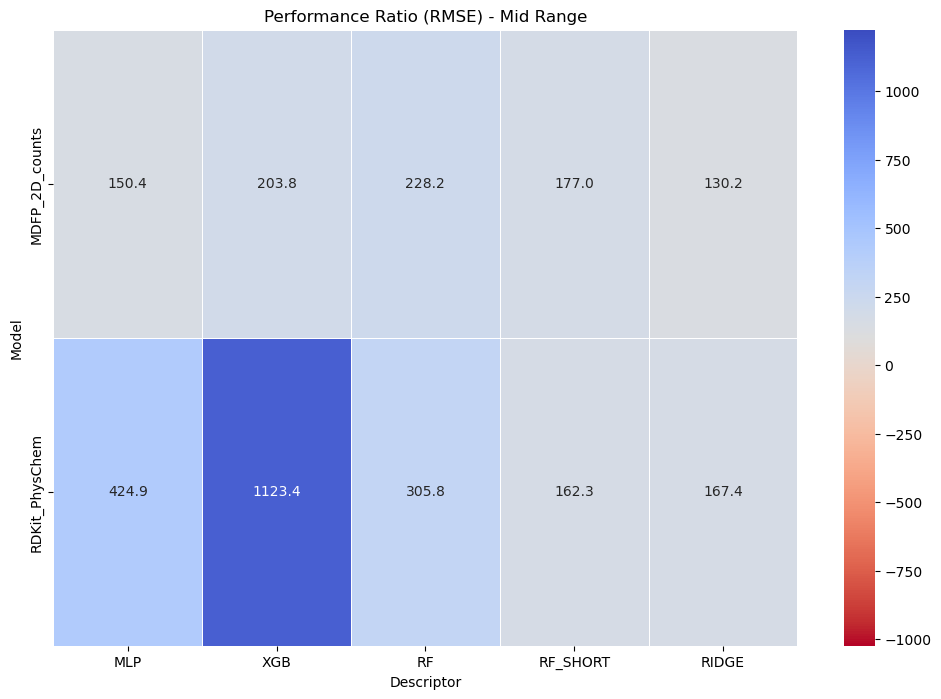

In [272]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from utils.stats import get_stats

def load_data(train_path_full, train_path_mid, test_path):
    train_data_full = pd.read_pickle(train_path_full)
    train_data_mid = pd.read_pickle(train_path_mid)
    test_data = pd.read_pickle(test_path)
    return train_data_full, train_data_mid, test_data

def calculate_metrics_with_naming(data, predictions_key, metric_names=['KendallTau', 'RMSE', 'MAE', 'MedianAE']):
    reals_list = data['reals_list']
    predictions_dict = data[predictions_key]
    all_stats = []

    for (model, descriptor), predictions in predictions_dict.items():
        metric_data = {metric: [] for metric in metric_names}
        for real, pred in zip(reals_list, predictions):
            real = np.array(real)
            pred = np.array(pred)
            stats = get_stats(real, pred, [1])
            for metric_name in metric_names:
                metric_data[metric_name].append(stats[metric_name])

        for metric_name in metric_names:
            mean_val = np.mean(metric_data[metric_name])
            all_stats.append({
                'Model': model,
                'Descriptor': descriptor,
                'Metric': metric_name,
                'Mean': mean_val
            })

    metrics_df = pd.DataFrame(all_stats)
    return metrics_df

def compute_performance_ratio(train_df, test_df, metric_name):
    ratios = {}
    for model, descriptor in zip(train_df['Model'], train_df['Descriptor']):
        train_val = train_df.loc[
            (train_df['Model'] == model) & (train_df['Descriptor'] == descriptor) & (train_df['Metric'] == metric_name),
            'Mean'
        ].values[0]
        test_val = test_df.loc[
            (test_df['Model'] == model) & (test_df['Descriptor'] == descriptor) & (test_df['Metric'] == metric_name),
            'Mean'
        ].values[0]
        ratio = (test_val / train_val) * 100
        ratios[(model, descriptor)] = ratio
    return ratios

def plot_heatmap(df, title, vmin=50, vmax=150, cmap='coolwarm_r'):
    plt.figure(figsize=(12, 8))
    sns.heatmap(df, annot=True, cmap=cmap, vmin=vmin, vmax=vmax, fmt=".1f", center=100, linewidths=.5)
    plt.title(title)
    plt.show()

def analyze_overfitting_with_naming(
    train_path_full,
    train_path_mid,
    test_path,
    metric_names=['KendallTau', 'RMSE', 'MAE', 'MedianAE'],
    model_order = ['MLP', 'XGB', 'RF', 'RF_SHORT', 'RIDGE'],
    show_mdfp = False
):
    train_data_full, train_data_mid, test_data = load_data(train_path_full, train_path_mid, test_path)
    df_train_full = calculate_metrics_with_naming(train_data_full, 'predictions_on_train_full_range', metric_names)
    df_train_mid = calculate_metrics_with_naming(train_data_mid, 'predictions_on_train_mid_range', metric_names)
    df_test = calculate_metrics_with_naming(test_data, 'predictions_train_full_range', metric_names)


    for metric_name in metric_names:
        performance_ratios_full = compute_performance_ratio(df_train_full, df_test, metric_name)
        performance_ratios_mid = compute_performance_ratio(df_train_mid, df_test, metric_name)

        full_data = [
            {'Model': model, 'Descriptor': descriptor, 'Performance (%)': ratio}
            for (model, descriptor), ratio in performance_ratios_full.items()
        ]
        mid_data = [
            {'Model': model, 'Descriptor': descriptor, 'Performance (%)': ratio}
            for (model, descriptor), ratio in performance_ratios_mid.items()
        ]

        df_full = pd.DataFrame(full_data)
        df_mid = pd.DataFrame(mid_data)

        heatmap_df_full = df_full.pivot(index='Model', columns='Descriptor', values='Performance (%)')
        heatmap_df_mid = df_mid.pivot(index='Model', columns='Descriptor', values='Performance (%)')
        if not show_mdfp:
            heatmap_df_full = heatmap_df_full.drop('MDFP', axis=0)
            heatmap_df_mid = heatmap_df_mid.drop('MDFP', axis=0)
        print(heatmap_df_full)
        print(heatmap_df_mid)
        #change column order
        heatmap_df_full = heatmap_df_full[model_order]
        heatmap_df_mid = heatmap_df_mid[model_order]

        #get max abs value for both heatmaps
        max_val_full = max(abs(heatmap_df_full.values.min()),heatmap_df_full.values.max())
        max_val_mid = max(abs(heatmap_df_mid.values.min()),heatmap_df_mid.values.max())
        
        plot_heatmap(heatmap_df_full, title=f'Performance Ratio ({metric_name}) - Full Range',vmin=100-max_val_full, vmax=100+max_val_full)
        plot_heatmap(heatmap_df_mid, title=f'Performance Ratio ({metric_name}) - Mid Range',vmin=100-max_val_mid, vmax=100+max_val_mid)

        return heatmap_df_full, heatmap_df_mid

# Example usage
heatmap_df_full, heatmap_df_mid = analyze_overfitting_with_naming(
    train_path_full='results/train_set_full_results_physchem_MDFP_2D_counts.pkl',
    train_path_mid='results/train_set_mid_results_physchem_MDFP_2D_counts.pkl',
    test_path='results/test_set_results_physchem_MDFP_2D_counts.pkl',
    metric_names=['RMSE']
)


In [273]:
heatmap_data1, heatmap_data2, heatmap_diff,heatmap_df_mid
#in heatmap_df_mid, rename MDFP_2D_counts to 2D_counts
heatmap_df_mid = heatmap_df_mid.rename(index={'MDFP_2D_counts': '2D_counts'})


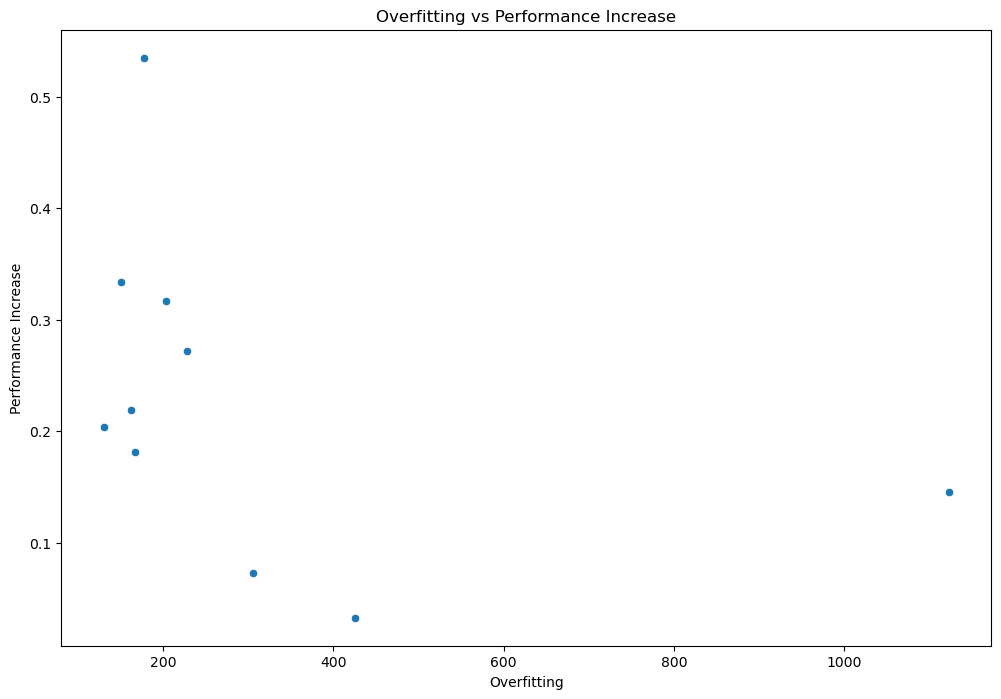

In [274]:
overfittings,performance_increases,models,descriptors = [],[],[],[]
for model in heatmap_df_mid.columns:
    for descriptor in heatmap_df_mid.index:
        overfitting = heatmap_df_mid.loc[descriptor,model]
        performance_increase = heatmap_diff.loc[descriptor,model]
        overfittings.append(overfitting)
        performance_increases.append(performance_increase)
        models.append(model)
        descriptors.append(descriptor)
df_overfitting = pd.DataFrame({'Overfitting':overfittings,'Performance Increase':performance_increases,'Model':models,'Descriptor':descriptors})
# #scatter
plt.figure(figsize=(12, 8))
sns.scatterplot(x='Overfitting',y='Performance Increase',data=df_overfitting)
plt.xlabel('Overfitting')
plt.ylabel('Performance Increase')
plt.title('Overfitting vs Performance Increase')
plt.show()

In [275]:
fig = px.scatter(
    df_overfitting,
    x='Overfitting',
    y='Performance Increase',
    color='Model',
    symbol='Descriptor',
    labels={
        'Train_Mid_as_percentage_of_Train_Full': 'Performance (Clean Data as % of Noisy Data)',
        'Test_Mid_as_percentage_of_Train_Mid': 'Test Performance (% of Train Performance)'
    },
    title="Model Behavior: Training on Clean vs Noisy Data"
)

# Update layout for clarity
fig.update_layout(
    width=1200,
    height=800,
    legend=dict(
        title="Legend",
        orientation="h",
        yanchor="bottom",
        y=-0.3,
        xanchor="center",
        x=0.5
    ),
    margin=dict(l=50, r=50, t=60, b=100),
    font=dict(size=14),
    title_font=dict(size=18),
    title_x=0.5,  # Center title
)

# Update marker styles for better distinction
fig.update_traces(marker=dict(size=12, line=dict(width=2, color='DarkSlateGrey')))

# Add gridlines and improve axis visibility
fig.update_xaxes(
    title="Training Performance (Clean Data as % of Noisy Data)",
    showgrid=True,
    gridwidth=1,
    gridcolor='LightGrey',
    zeroline=True,
    zerolinewidth=1,
    zerolinecolor='Black'
)
fig.update_yaxes(
    title="Test Performance (% of Train Performance)",
    showgrid=True,
    gridwidth=1,
    gridcolor='LightGrey',
    zeroline=True,
    zerolinewidth=1,
    zerolinecolor='Black'
)

fig.show()

In [276]:
df_overfitting_physchem_only = df_overfitting[df_overfitting['Descriptor'] != '2D_counts']
fig = px.scatter(
    df_overfitting_physchem_only,
    x='Overfitting',
    y='Performance Increase',
    color='Model',
    symbol='Descriptor',
    labels={
        'Train_Mid_as_percentage_of_Train_Full': 'Performance (Clean Data as % of Noisy Data)',
        'Test_Mid_as_percentage_of_Train_Mid': 'Test Performance (% of Train Performance)'
    },
    title="Model Behavior: Training on Clean vs Noisy Data"
)

# Update layout for clarity
fig.update_layout(
    width=1200,
    height=800,
    legend=dict(
        title="Legend",
        orientation="h",
        yanchor="bottom",
        y=-0.3,
        xanchor="center",
        x=0.5
    ),
    margin=dict(l=50, r=50, t=60, b=100),
    font=dict(size=14),
    title_font=dict(size=18),
    title_x=0.5,  # Center title
)

# Update marker styles for better distinction
fig.update_traces(marker=dict(size=12, line=dict(width=2, color='DarkSlateGrey')))

# Add gridlines and improve axis visibility
fig.update_xaxes(
    title="Training Performance (Clean Data as % of Noisy Data)",
    showgrid=True,
    gridwidth=1,
    gridcolor='LightGrey',
    zeroline=True,
    zerolinewidth=1,
    zerolinecolor='Black'
)
fig.update_yaxes(
    title="Test Performance (% of Train Performance)",
    showgrid=True,
    gridwidth=1,
    gridcolor='LightGrey',
    zeroline=True,
    zerolinewidth=1,
    zerolinecolor='Black'
)

fig.show()

In [277]:
df_overfitting_physchem_only

,Overfitting,Performance Increase,Model,Descriptor
1,424.910117,0.032512,MLP,RDKit_PhysChem
3,1123.411645,0.145492,XGB,RDKit_PhysChem
5,305.843936,0.073023,RF,RDKit_PhysChem
7,162.322298,0.219270,RF_SHORT,RDKit_PhysChem
9,167.364412,0.181404,RIDGE,RDKit_PhysChem
